In [15]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Set seed for reproducibility
random.seed(42)

# Generate GPU names
gpu_list = [
    "NVIDIA RTX 3060", "NVIDIA RTX 3070", "NVIDIA RTX 3080",
    "AMD RX 6600", "AMD RX 6700 XT", "NVIDIA RTX 4060", "AMD RX 7900 XTX"
]

# Function to generate fake data
def generate_fake_gpu_data(source_name, num_days=180):
    data = []
    today = datetime.today()

    for i in range(num_days):
        date = today - timedelta(days=i)
        for gpu in gpu_list:
            base_price = random.randint(25000, 95000)
            price_variation = random.randint(-3000, 3000)

            # Simulate rating and review count
            rating = round(random.uniform(3.5, 5.0), 1)
            reviews = random.randint(100, 2000)

            data.append({
                "date": date.strftime("%Y-%m-%d"),
                "gpu_name": gpu,
                "price": base_price + price_variation,
                "rating": rating,
                "reviews": reviews,
                "source": source_name
            })

    return pd.DataFrame(data)

# Generate data
flipkart_df = generate_fake_gpu_data("Flipkart")
amazon_df = generate_fake_gpu_data("Amazon")
aliexpress_df = generate_fake_gpu_data("AliExpress")

# Save to CSV (for later use)
flipkart_df.to_csv("flipkart_gpu_data.csv", index=False)
amazon_df.to_csv("amazon_gpu_data.csv", index=False)
aliexpress_df.to_csv("aliexpress_gpu_data.csv", index=False)

# Preview
flipkart_df.head()


,date,gpu_name,price,rating,reviews,source
0,2025-04-04,NVIDIA RTX 3060,36796,4.6,601,Flipkart
1,2025-04-04,NVIDIA RTX 3070,52399,4.6,1485,Flipkart
2,2025-04-04,NVIDIA RTX 3080,38232,4.1,161,Flipkart
3,2025-04-04,AMD RX 6600,36071,3.8,1332,Flipkart
4,2025-04-04,AMD RX 6700 XT,30075,3.8,1430,Flipkart


In [16]:
import pandas as pd

# Load individual CSVs
flipkart_df = pd.read_csv("/content/flipkart_gpu_data.csv")
amazon_df = pd.read_csv("/content/amazon_gpu_data.csv")
aliexpress_df = pd.read_csv("/content/aliexpress_gpu_data.csv")

# ✅ Rename columns to specify source clearly
flipkart_df = flipkart_df.rename(columns={
    "price": "flipkart_price",
    "rating": "flipkart_rating",
    "reviews": "flipkart_reviews"
})

amazon_df = amazon_df.rename(columns={
    "price": "amazon_price",
    "rating": "amazon_rating",
    "reviews": "amazon_reviews"
})

aliexpress_df = aliexpress_df.rename(columns={
    "price": "aliexpress_price",
    "rating": "aliexpress_rating",
    "reviews": "aliexpress_reviews"
})

# ✅ Drop 'source' column from all datasets (optional)
for df in [flipkart_df, amazon_df, aliexpress_df]:
    if "source" in df.columns:
        df.drop(columns=["source"], inplace=True)

# ✅ Merge Flipkart with Amazon on date + gpu_name
merged_df = pd.merge(
    flipkart_df,
    amazon_df,
    on=["date", "gpu_name"],
    how="left"
)

# ✅ Merge the result with AliExpress
merged_df = pd.merge(
    merged_df,
    aliexpress_df,
    on=["date", "gpu_name"],
    how="left"
)

# ✅ Save merged dataframe to CSV
merged_df.to_csv("merged_gpu_data.csv", index=False)

# ✅ Preview
print("🎉 Merged data successfully saved to 'merged_gpu_data.csv'")
print(merged_df.head())


🎉 Merged data successfully saved to 'merged_gpu_data.csv'
         date         gpu_name  flipkart_price  flipkart_rating  \
0  2025-04-04  NVIDIA RTX 3060           36796              4.6   
1  2025-04-04  NVIDIA RTX 3070           52399              4.6   
2  2025-04-04  NVIDIA RTX 3080           38232              4.1   
3  2025-04-04      AMD RX 6600           36071              3.8   
4  2025-04-04   AMD RX 6700 XT           30075              3.8   

   flipkart_reviews  amazon_price  amazon_rating  amazon_reviews  \
0               601         50944            4.5             641   
1              1485         49915            4.5            1988   
2               161         86323            4.4             570   
3              1332         74729            3.7             133   
4              1430         52804            4.8            1132   

   aliexpress_price  aliexpress_rating  aliexpress_reviews  
0             81067                4.1                 690  
1       

In [18]:
import pandas as pd
import random

# Load merged dataset
merged_df = pd.read_csv("/content/merged_gpu_data.csv")

# 🟢 1. Derived Columns: Price Difference
merged_df["price_diff_amazon"] = merged_df["flipkart_price"] - merged_df["amazon_price"]
merged_df["price_diff_aliexpress"] = merged_df["flipkart_price"] - merged_df["aliexpress_price"]

# 🟢 2. Average Rating across all platforms
merged_df["average_rating"] = merged_df[[
    "flipkart_rating", "amazon_rating", "aliexpress_rating"
]].mean(axis=1)

# 🟢 3. Discount Flag: 1 if Flipkart price is lower than both Amazon and AliExpress
merged_df["discount_flag"] = (
    (merged_df["flipkart_price"] < merged_df["amazon_price"]) &
    (merged_df["flipkart_price"] < merged_df["aliexpress_price"])
).astype(int)

# 🟢 4. Simulate 'units_sold' using price & rating signals
def simulate_units_sold(row):
    base_sales = random.randint(10, 50)  # Random base sales
    price_factor = -0.005 * row["price_diff_amazon"]  # Cheaper = more sales
    rating_factor = 2.5 * (row["flipkart_rating"] - 3.5)  # Better rating = more sales
    units_sold = int(base_sales + price_factor + rating_factor)
    return max(1, units_sold)  # Minimum 1 unit

merged_df["units_sold"] = merged_df.apply(simulate_units_sold, axis=1)

# 🟢 5. Calculate Revenue
merged_df["revenue"] = merged_df["flipkart_price"] * merged_df["units_sold"]

# 💾 Save final dataset
merged_df.to_csv("final_gpu_data.csv", index=False)

# ✅ Preview
print("🎯 Final dataset with derived features and target labels saved as 'final_gpu_data.csv'")
print(merged_df.head())


🎯 Final dataset with derived features and target labels saved as 'final_gpu_data.csv'
         date         gpu_name  flipkart_price  flipkart_rating  \
0  2025-04-04  NVIDIA RTX 3060           36796              4.6   
1  2025-04-04  NVIDIA RTX 3070           52399              4.6   
2  2025-04-04  NVIDIA RTX 3080           38232              4.1   
3  2025-04-04      AMD RX 6600           36071              3.8   
4  2025-04-04   AMD RX 6700 XT           30075              3.8   

   flipkart_reviews  amazon_price  amazon_rating  amazon_reviews  \
0               601         50944            4.5             641   
1              1485         49915            4.5            1988   
2               161         86323            4.4             570   
3              1332         74729            3.7             133   
4              1430         52804            4.8            1132   

   aliexpress_price  aliexpress_rating  aliexpress_reviews  price_diff_amazon  \
0             81067  

📦 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1260 non-null   datetime64[ns]
 1   gpu_name               1260 non-null   object        
 2   flipkart_price         1260 non-null   int64         
 3   flipkart_rating        1260 non-null   float64       
 4   flipkart_reviews       1260 non-null   int64         
 5   amazon_price           1260 non-null   int64         
 6   amazon_rating          1260 non-null   float64       
 7   amazon_reviews         1260 non-null   int64         
 8   aliexpress_price       1260 non-null   int64         
 9   aliexpress_rating      1260 non-null   float64       
 10  aliexpress_reviews     1260 non-null   int64         
 11  price_diff_amazon      1260 non-null   int64         
 12  price_diff_aliexpress  1260 non-null   int

<ipython-input-21-2ecfed890c91>:37: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


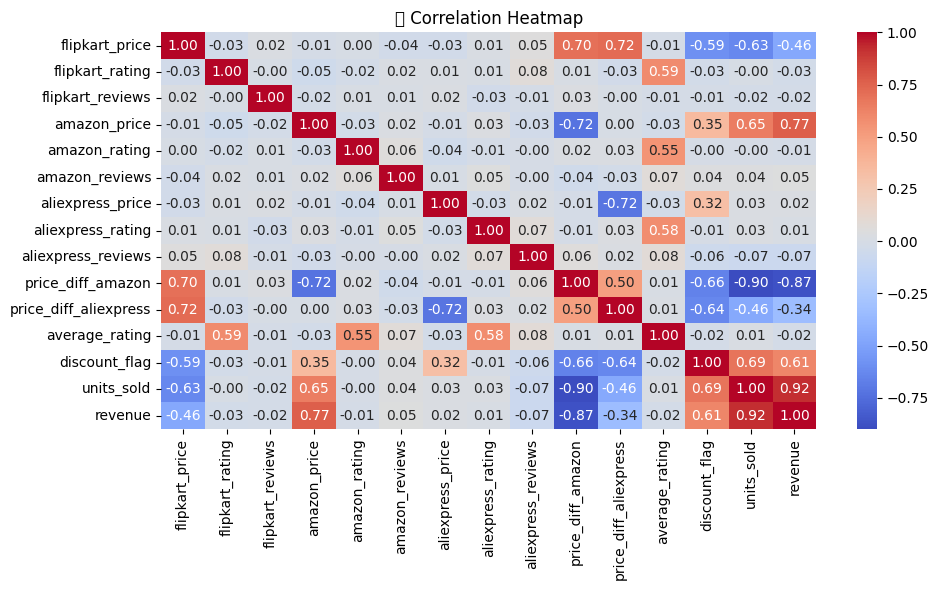

<ipython-input-21-2ecfed890c91>:59: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-2ecfed890c91>:59: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-2ecfed890c91>:59: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-2ecfed890c91>:59: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtool

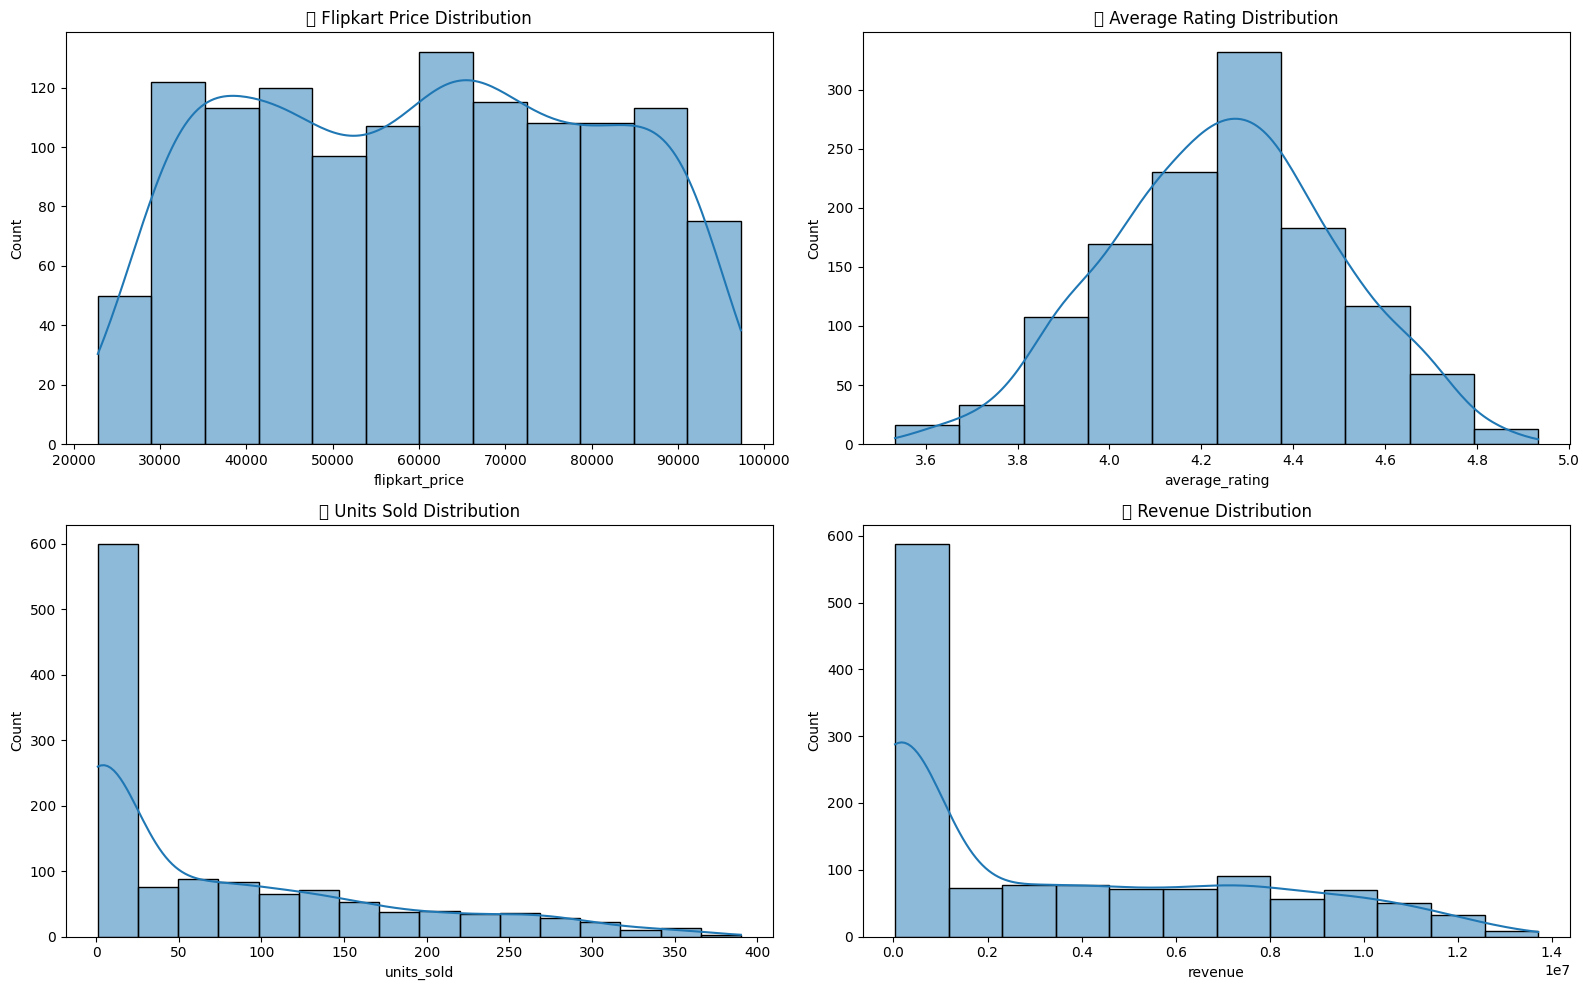

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


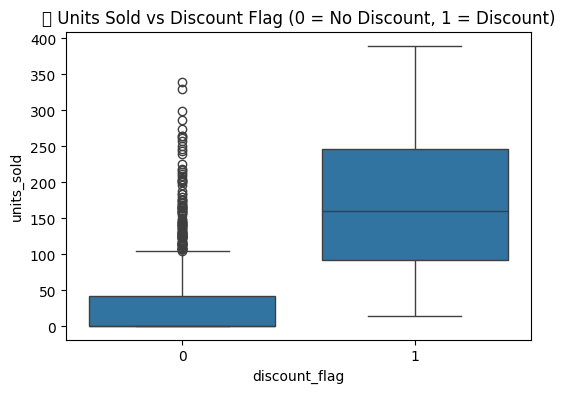

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


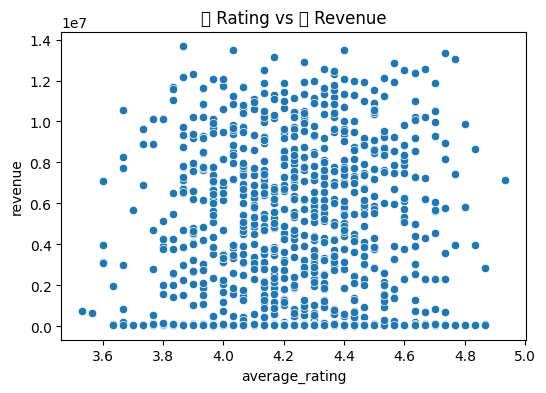

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


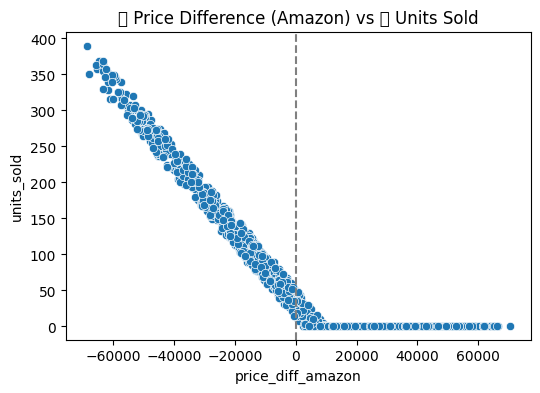

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/final_gpu_data.csv")

# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Extract numerical features for correlation analysis
numerical_features = df.select_dtypes(include=['number'])

# 🔍 1. Basic Info
print("📦 Dataset Overview:")
print(df.info())
print("\n")

# 🔢 2. Summary Statistics
print("📈 Descriptive Statistics:")
print(df.describe())
print("\n")

# 🧼 3. Check for Missing Values
print("🧹 Missing Values:")
print(df.isnull().sum())
print("\n")

# 🧻 4. Duplicates
print("🔁 Duplicate Records:", df.duplicated().sum())
print("\n")

# 🧠 5. Correlation Matrix
plt.figure(figsize=(10,6))
sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap="coolwarm") # Use numerical_features here
plt.title("🔗 Correlation Heatmap")
plt.tight_layout()
plt.show()

# 📊 6. Distribution Plots
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.histplot(df["flipkart_price"], kde=True)
plt.title("🛒 Flipkart Price Distribution")

plt.subplot(2, 2, 2)
sns.histplot(df["average_rating"], bins=10, kde=True)
plt.title("⭐ Average Rating Distribution")

plt.subplot(2, 2, 3)
sns.histplot(df["units_sold"], kde=True)
plt.title("📦 Units Sold Distribution")

plt.subplot(2, 2, 4)
sns.histplot(df["revenue"], kde=True)
plt.title("💰 Revenue Distribution")

plt.tight_layout()
plt.show()

# 🔍 7. Discount Effect on Units Sold
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="discount_flag", y="units_sold")
plt.title("🎯 Units Sold vs Discount Flag (0 = No Discount, 1 = Discount)")
plt.show()

# 🔍 8. Rating vs Revenue
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="average_rating", y="revenue")
plt.title("⭐ Rating vs 💰 Revenue")
plt.show()

# 🔍 9. Price Diff vs Units Sold
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="price_diff_amazon", y="units_sold")
plt.title("💸 Price Difference (Amazon) vs 📦 Units Sold")
plt.axvline(0, color='gray', linestyle='--')
plt.show()


      gpu_name       date  units_sold  revenue  average_rating
0  AMD RX 6600 2024-10-07          72  2184048        4.300000
1  AMD RX 6600 2024-10-08           1    55587        4.200000
2  AMD RX 6600 2024-10-09          59  2149606        4.133333
3  AMD RX 6600 2024-10-10         293  9494372        4.000000
4  AMD RX 6600 2024-10-11           1    75274        4.600000


<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


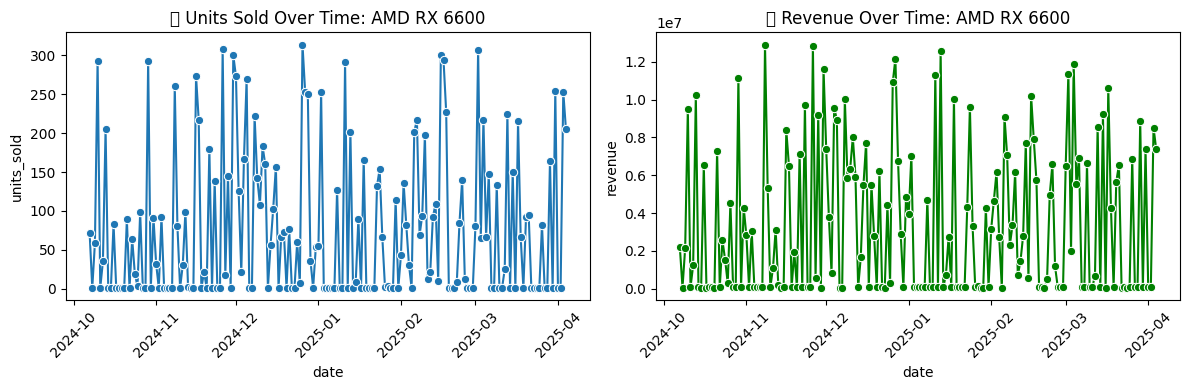

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


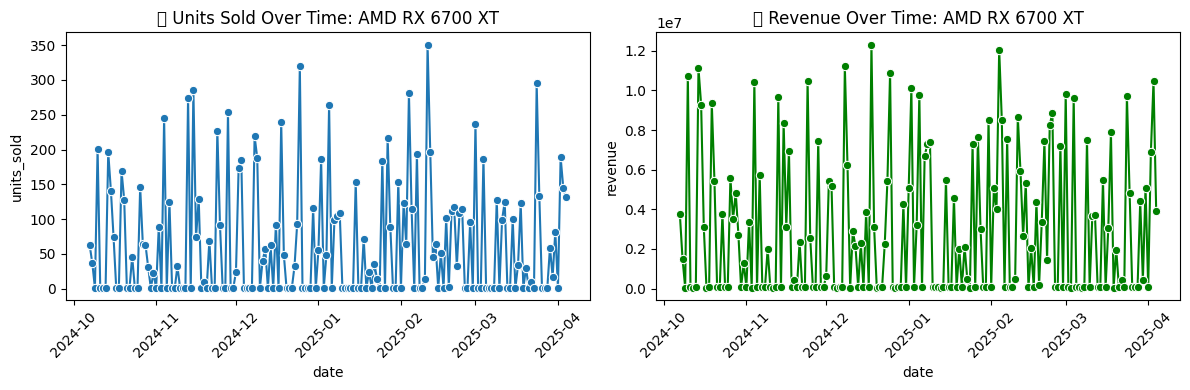

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


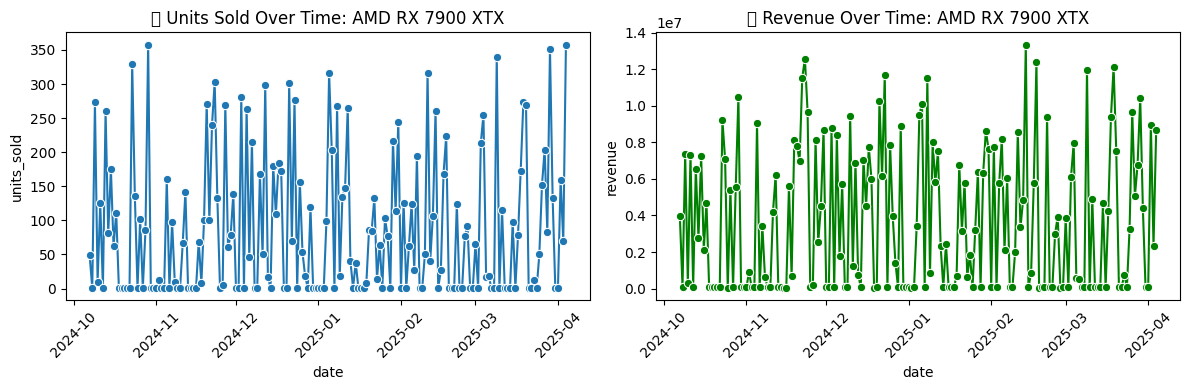

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


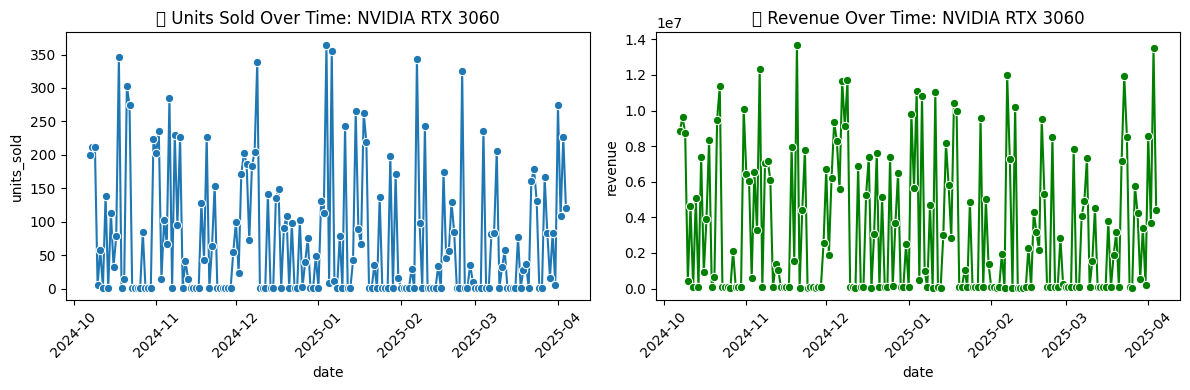

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


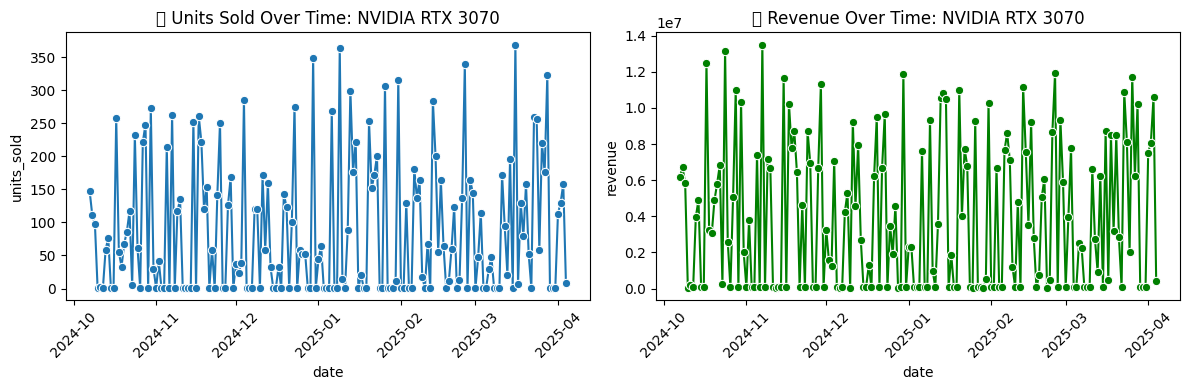

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


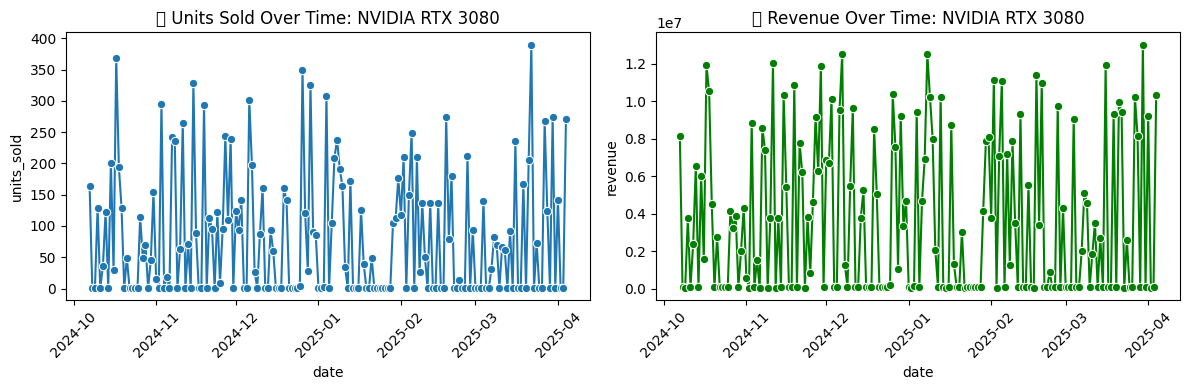

<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-0cba319de545>:40: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


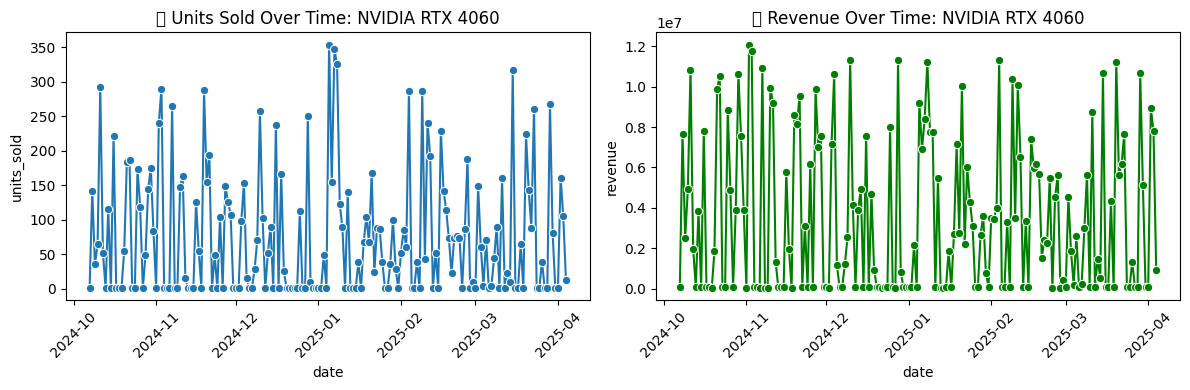

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load final dataset
df = pd.read_csv("/content/final_gpu_data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by GPU model and date
grouped = df.groupby(['gpu_name', 'date']).agg({
    'units_sold': 'sum',
    'revenue': 'sum',
    'average_rating': 'mean'
}).reset_index()

# ✅ Preview grouped data
print(grouped.head())

# 📈 Plot time series for each GPU
unique_gpus = grouped['gpu_name'].unique()

# Plotting all GPU models separately
for gpu in unique_gpus:
    gpu_data = grouped[grouped['gpu_name'] == gpu]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=gpu_data, x='date', y='units_sold', marker="o")
    plt.title(f"📦 Units Sold Over Time: {gpu}")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.lineplot(data=gpu_data, x='date', y='revenue', marker="o", color='green')
    plt.title(f"💰 Revenue Over Time: {gpu}")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


Target: Let's Predict units_sold

               Model   RMSE  R2 Score
0  Linear Regression  39.64      0.81
1      Decision Tree  12.69      0.98
2      Random Forest   9.77      0.99
3            XGBoost   9.94      0.99


<ipython-input-25-7ea73efccdcc>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2 Score', palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


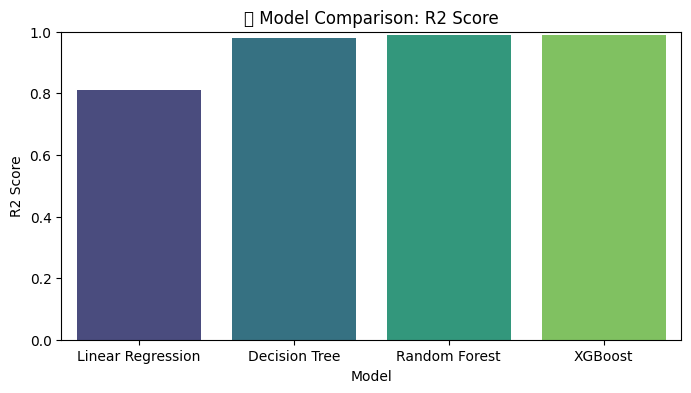

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/content/final_gpu_data.csv")

# 🎯 Features & Target
features = [
    'flipkart_price',
    'price_diff_amazon',
    'price_diff_aliexpress',
    'average_rating',
    'discount_flag'
]
target = 'units_sold'

X = df[features]
y = df[target]

# ✂️ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Models to test
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE without the 'squared' parameter
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5  # Manually calculate RMSE

    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    })

# 📊 Results Summary
results_df = pd.DataFrame(results)
print(results_df)

# 📈 Visualize
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x='Model', y='R2 Score', palette='viridis')
plt.title("📊 Model Comparison: R2 Score")
plt.ylim(0, 1)
plt.show()

Predict revenue instead of units_sold.

               Model        RMSE  R2 Score
0  Linear Regression  1676529.51      0.79
1      Decision Tree   759606.99      0.96
2      Random Forest   567034.43      0.98
3            XGBoost   615308.90      0.97


<ipython-input-28-39b916b05583>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2 Score', palette='plasma')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


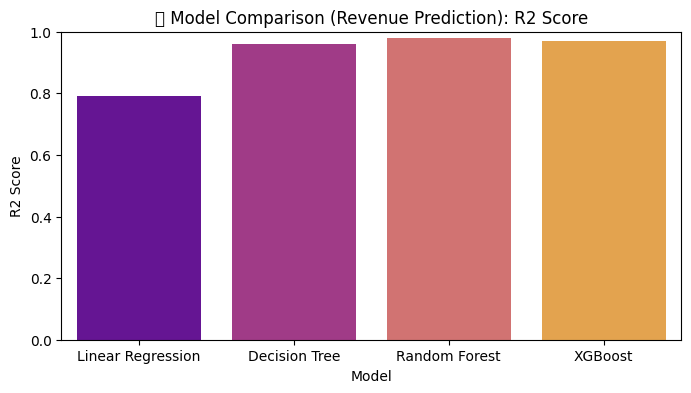

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/final_gpu_data.csv")

# 🎯 Features & New Target (revenue)
features = [
    'flipkart_price',
    'price_diff_amazon',
    'price_diff_aliexpress',
    'average_rating',
    'discount_flag'
]
target = 'revenue'

X = df[features]
y = df[target]

# ✂️ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE manually if 'squared' parameter is not available
    mse = mean_squared_error(y_test, y_pred) # Remove squared=False
    rmse = mse**0.5  # Take the square root to get RMSE

    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 2)
    })

# 📊 Results Summary
results_df = pd.DataFrame(results)
print(results_df)

# 📈 Visualize R2 Score
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x='Model', y='R2 Score', palette='plasma')
plt.title("📊 Model Comparison (Revenue Prediction): R2 Score")
plt.ylim(0, 1)
plt.show()

In [32]:
pip install matplotlib pandas reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s eta 0:00:00


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.platypus import Image
from datetime import datetime
import os

# Load your final GPU data
df = pd.read_csv("/content/final_gpu_data.csv")
df["date"] = pd.to_datetime(df["date"])

# Grouped summary
summary = df.describe()

# Create chart output folder
os.makedirs("charts", exist_ok=True)

# 📈 1. Line Chart: Total Revenue Over Time
revenue_trend = df.groupby("date")["revenue"].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(revenue_trend["date"], revenue_trend["revenue"], marker="o")
plt.title("Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (INR)")
plt.tight_layout()
plt.grid(True)
plt.savefig("charts/revenue_trend.png")
plt.close()

# 📦 2. Line Chart: Units Sold Over Time
units_trend = df.groupby("date")["units_sold"].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(units_trend["date"], units_trend["units_sold"], marker="o", color="orange")
plt.title("Total Units Sold Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.grid(True)
plt.savefig("charts/units_trend.png")
plt.close()

# ⭐ 3. Average Rating Over Time
rating_trend = df.groupby("date")["average_rating"].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(rating_trend["date"], rating_trend["average_rating"], marker="o", color="green")
plt.title("Average Rating Over Time")
plt.xlabel("Date")
plt.ylabel("Rating")
plt.tight_layout()
plt.grid(True)
plt.savefig("charts/rating_trend.png")
plt.close()

# 📝 4. Generate PDF with ReportLab
pdf_path = "GPU_Report.pdf"
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4

# Title
c.setFont("Helvetica-Bold", 20)
c.drawCentredString(width / 2, height - 50, "📊 GPU Sales & Pricing Report")
c.setFont("Helvetica", 12)
c.drawCentredString(width / 2, height - 70, f"Generated on: {datetime.today().strftime('%Y-%m-%d')}")

# Summary Stats
c.setFont("Helvetica-Bold", 14)
c.drawString(40, height - 110, "📋 Summary Statistics (Flipkart Prices & Revenue)")
c.setFont("Helvetica", 10)

# Display just top metrics from summary
y = height - 130
for col in ["flipkart_price", "units_sold", "revenue"]:
    stats = summary[col]
    c.drawString(50, y, f"{col}: mean={stats['mean']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")
    y -= 15

# Charts Section
def add_chart(c, path, title, y_pos):
    c.setFont("Helvetica-Bold", 12)
    c.drawString(40, y_pos, f"📈 {title}")
    c.drawImage(path, 50, y_pos - 200, width=500, height=150, preserveAspectRatio=True)

add_chart(c, "charts/revenue_trend.png", "Revenue Over Time", height - 180)
add_chart(c, "charts/units_trend.png", "Units Sold Over Time", height - 400)
c.showPage()  # new page for more

add_chart(c, "charts/rating_trend.png", "Average Rating Over Time", height - 100)

# Add insights/comments
c.setFont("Helvetica-Bold", 14)
c.drawString(40, height - 270, "🧠 Key Insights:")

c.setFont("Helvetica", 11)
insights = [
    "1. Revenue and units sold show a positive trend over time.",
    "2. Discounts (when Flipkart is cheaper than competitors) increase units sold.",
    "3. Products with average ratings above 4.0 tend to generate higher revenue.",
    "4. Price difference from Amazon has a noticeable impact on sales volume."
]
y = height - 290
for insight in insights:
    c.drawString(50, y, insight)
    y -= 15

# Save PDF
c.save()

print("✅ PDF report generated as 'GPU_Report.pdf'")


✅ PDF report generated as 'GPU_Report.pdf'


In [34]:
import pandas as pd

# Load merged and feature-enriched dataset
df = pd.read_csv("/content/final_gpu_data.csv")

# Optional: convert date to standard format
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d')  # clean string for Tableau

# Export to final Tableau CSV
df.to_csv("gpu_data_for_tableau.csv", index=False)
print("✅ Exported clean dataset for Tableau as gpu_data_for_tableau.csv")


✅ Exported clean dataset for Tableau as gpu_data_for_tableau.csv
